## 读取K线数据，获取大户持仓量多空比数据

In [1]:
import os
import logging

from binance_sdk_derivatives_trading_usds_futures.derivatives_trading_usds_futures import (
    DerivativesTradingUsdsFutures,
    ConfigurationRestAPI,
    DERIVATIVES_TRADING_USDS_FUTURES_REST_API_PROD_URL,
)
from binance_sdk_derivatives_trading_usds_futures.rest_api.models import (
    KlineCandlestickDataIntervalEnum,
    TopTraderLongShortRatioPositionsPeriodEnum
)


# Configure logging
logging.basicConfig(level=logging.INFO)

# Create configuration for the REST API
configuration_rest_api = ConfigurationRestAPI(
    api_key="66aLkztQkQFuyUQuM83oqYx9ENuZH1SFFbuTSP3ClcGYa9Vqwy5cmQan9QfK7Gzd",
    # api_key= "O0ambiAxVnDs0pDAtlwVs3uiLR7uH2kh5B12WWWmEersKD9uHipkJZ80I90enw4o",
    # api_secret="",
    api_secret="V4lTk3PUCa7jwGAxPybBFzE7fN2Ob09FZR9BbchLOiGtssRnH9cnkfL2O8C7aoQW",
    base_path=os.getenv(
        "BASE_PATH",  DERIVATIVES_TRADING_USDS_FUTURES_REST_API_PROD_URL)
)

# Initialize DerivativesTradingUsdsFutures client

client = DerivativesTradingUsdsFutures(config_rest_api=configuration_rest_api)

# 获取 K线数据
def kline_candlestick_data():
    try:
        response = client.rest_api.kline_candlestick_data(
            symbol="TRADOORUSDT",
            interval=KlineCandlestickDataIntervalEnum["INTERVAL_1h"].value,
            limit=500,
        )

        rate_limits = response.rate_limits
        logging.info(f"kline_candlestick_data() rate limits: {rate_limits}")

        data = response.data()
        return data
        logging.info(f"kline_candlestick_data() response: {data}")
    except Exception as e:
        logging.error(f"kline_candlestick_data() error: {e}")

# 获取大户持仓量多空比数据
def top_trader_long_short_ratio_positions():
    try:
        response = client.rest_api.top_trader_long_short_ratio_positions(
            symbol="TRADOORUSDT",
            period=TopTraderLongShortRatioPositionsPeriodEnum["PERIOD_1h"].value,
            limit=500,
        )

        rate_limits = response.rate_limits
        logging.info(
            f"top_trader_long_short_ratio_positions() rate limits: {rate_limits}"
        )

        data = response.data()
        return data
        logging.info(f"top_trader_long_short_ratio_positions() response: {data}")
    except Exception as e:
        logging.error(f"top_trader_long_short_ratio_positions() error: {e}")

klines =  kline_candlestick_data()        
top_long_short_ratio = top_trader_long_short_ratio_positions()

INFO:root:kline_candlestick_data() rate limits: [RateLimit(rateLimitType='REQUEST_WEIGHT', interval='MINUTE', intervalNum=1, count=23, retryAfter=None)]
INFO:root:top_trader_long_short_ratio_positions() rate limits: []


## 将K线数据转换为DataFrame

In [3]:
def kline_candlestick_data(symbol,interval,starttime,endtime,limit):
    try:
        response = client.rest_api.kline_candlestick_data(
            symbol=symbol,
            interval=interval,
            start_time=starttime,
            end_time=endtime,
            limit=limit,
        )

        rate_limits = response.rate_limits
        logging.info(f"kline_candlestick_data() rate limits: {rate_limits}")

        data = response.data()
        return data
        logging.info(f"kline_candlestick_data() response: {data}")
    except Exception as e:
        logging.error(f"kline_candlestick_data() error: {e}")

In [11]:
from datetime import datetime
start_time = datetime(2022,1,1,0,0,0)
start_timestamp = int(start_time.timestamp() * 1000) 
klines = kline_candlestick_data('BTCUSDT','4h',start_timestamp,None,1500)

INFO:root:kline_candlestick_data() rate limits: [RateLimit(rateLimitType='REQUEST_WEIGHT', interval='MINUTE', intervalNum=1, count=136, retryAfter=None)]


In [12]:
import pandas as pd
def klines2df(data):
    df = pd.DataFrame(data, columns=[
        "trade_time", "open", "high", "low", "close",
        "volume", "close_time", "成交额", "成交笔数",
        "主动买入成交量", "主动买入成交额", "预留字段"
    ])
    
    # 数据类型转换（字符串→数值/日期）
    df["open"] = pd.to_numeric(df["open"])
    df["high"] = pd.to_numeric(df["high"])
    df["low"] = pd.to_numeric(df["low"])
    df["close"] = pd.to_numeric(df["close"])
    df["volume"] = pd.to_numeric(df["volume"])    
    # 时间戳转换为可读日期（毫秒级→秒级→datetime）
    df["trade_date"] = pd.to_datetime(df["trade_time"] // 1000, unit="s")
    df2 = df.set_index(df["trade_date"])
        
    return df2[["open","high","low","close","volume"]]

klines_df = klines2df(klines)

In [13]:
klines_df

,open,high,low,close,volume
trade_date,,,,,
2021-12-31 16:00:00,48004.76,48110.35,45656.00,45707.62,76988.381
2021-12-31 20:00:00,45707.62,46558.39,45650.00,46210.56,42513.339
2022-01-01 00:00:00,46210.57,46944.56,46210.55,46789.56,24921.419
2022-01-01 04:00:00,46789.55,47566.66,46605.00,47186.83,34840.019
2022-01-01 08:00:00,47186.83,47338.00,46700.09,46755.01,29421.287
...,...,...,...,...,...
2022-09-06 20:00:00,18813.10,19066.60,18600.00,18781.50,111169.830
2022-09-07 00:00:00,18781.40,18861.90,18500.00,18736.30,110548.940
2022-09-07 04:00:00,18736.20,18833.00,18664.20,18791.50,58734.217


In [159]:
import pandas as pd
def klines2df(data):
    df = pd.DataFrame(data, columns=[
        "trade_time", "open", "high", "low", "close",
        "volume", "close_time", "成交额", "成交笔数",
        "主动买入成交量", "主动买入成交额", "预留字段"
    ])
    
    # 数据类型转换（字符串→数值/日期）
    df["open"] = pd.to_numeric(df["open"])
    df["high"] = pd.to_numeric(df["high"])
    df["low"] = pd.to_numeric(df["low"])
    df["close"] = pd.to_numeric(df["close"])
    df["volume"] = pd.to_numeric(df["volume"])    
    # 时间戳转换为可读日期（毫秒级→秒级→datetime）
    df["trade_date"] = pd.to_datetime(df["trade_time"] // 1000, unit="s")
    df2 = df.set_index(df["trade_date"])
        
    return df2[["open","high","low","close","volume"]]

klines_df = klines2df(klines)

def top_long_short_ratio2df(data):
    df = pd.DataFrame(data)
    
    # 时间戳转换为可读日期（毫秒级→秒级→datetime）
    df["timestamp"] = pd.to_datetime(df["timestamp"] // 1000, unit="s")
    df['longShortRatio'] = pd.to_numeric(df['longShortRatio'])
    df['diff'] = df['longShortRatio']-df['longShortRatio'].shift(1)
    df['pct'] = df['diff'] / df['longShortRatio'].shift(1)
    df = df.drop(columns=['diff'])
    # df['longShortRatio'] = pd.to_numeric(df['longShortRatio'])
    df2 = df.set_index(df["timestamp"])
    
    
    return df2[['longShortRatio','pct']]
    
top_long_short_ratio_df=top_long_short_ratio2df(top_long_short_ratio)

  

## 绘制K线图

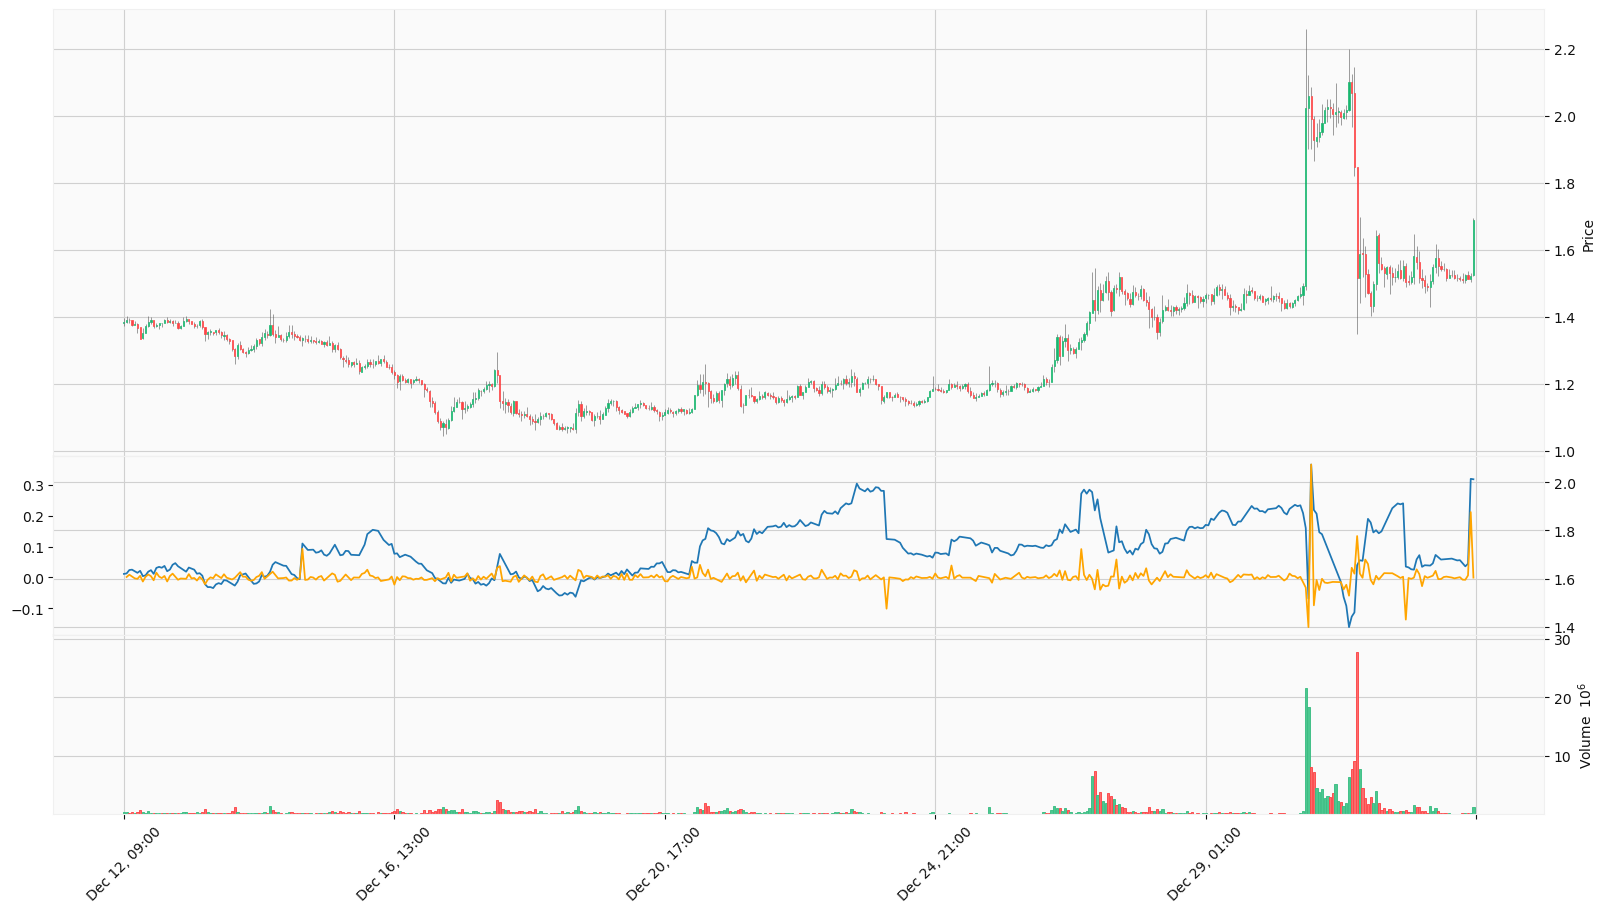

In [160]:
import mplfinance as mpf
import matplotlib.pyplot as plt
apd = mpf.make_addplot(top_long_short_ratio_df['longShortRatio'],panel=1)
apd2 = mpf.make_addplot(top_long_short_ratio_df['pct'],panel=1,color='orange')
# apd = mpf.make_addplot(pct,panel=1)
mpf.plot(klines_df, type='candle', style='yahoo', volume=True,volume_panel=2,figratio=(18,10),figscale=2,addplot=[apd,apd2])

plt.show()

In [94]:
top_long_short_ratio_df[450:500]

,longShortRatio,pct
timestamp,,
2025-12-31 02:00:00,2.2816,0.004402
2025-12-31 03:00:00,2.2835,0.000833
2025-12-31 04:00:00,2.2881,0.002014
2025-12-31 05:00:00,2.2775,-0.004633
2025-12-31 06:00:00,2.2798,0.001010
2025-12-31 07:00:00,2.2760,-0.001667
2025-12-31 08:00:00,2.2789,0.001274
2025-12-31 09:00:00,2.2684,-0.004607
2025-12-31 10:00:00,2.2703,0.000838


In [84]:
top_long_short_ratio_df

,longShortRatio,pct
timestamp,,
2025-12-02 04:00:00,1.6797,NaN
2025-12-02 05:00:00,1.6193,-0.035959
2025-12-02 06:00:00,1.6641,0.027666
2025-12-02 07:00:00,1.6633,-0.000481
2025-12-02 08:00:00,1.6541,-0.005531
...,...,...
2026-01-01 23:00:00,1.3569,0.013974
2026-01-02 00:00:00,1.3544,-0.001842
2026-01-02 01:00:00,1.3487,-0.004209


In [85]:
import os
import logging

from binance_sdk_derivatives_trading_usds_futures.derivatives_trading_usds_futures import (
    DerivativesTradingUsdsFutures,
    ConfigurationRestAPI,
    DERIVATIVES_TRADING_USDS_FUTURES_REST_API_PROD_URL,
)
from binance_sdk_derivatives_trading_usds_futures.rest_api.models import (
    TakerBuySellVolumePeriodEnum,
)


# Configure logging
logging.basicConfig(level=logging.INFO)

# Create configuration for the REST API
configuration_rest_api = ConfigurationRestAPI(
    api_key="66aLkztQkQFuyUQuM83oqYx9ENuZH1SFFbuTSP3ClcGYa9Vqwy5cmQan9QfK7Gzd",
    api_secret="V4lTk3PUCa7jwGAxPybBFzE7fN2Ob09FZR9BbchLOiGtssRnH9cnkfL2O8C7aoQW",
    base_path=os.getenv(
        "BASE_PATH",  DERIVATIVES_TRADING_USDS_FUTURES_REST_API_PROD_URL
    ),
)

# Initialize DerivativesTradingUsdsFutures client
client = DerivativesTradingUsdsFutures(config_rest_api=configuration_rest_api)


def taker_buy_sell_volume():
    try:
        response = client.rest_api.taker_buy_sell_volume(
            symbol="LIGHTUSDT",
            period=TakerBuySellVolumePeriodEnum["PERIOD_30m"].value,
        )

        rate_limits = response.rate_limits
        logging.info(f"taker_buy_sell_volume() rate limits: {rate_limits}")

        data = response.data()
        return data
        logging.info(f"taker_buy_sell_volume() response: {data}")
    except Exception as e:
        logging.error(f"taker_buy_sell_volume() error: {e}")



data=taker_buy_sell_volume()

INFO:root:taker_buy_sell_volume() rate limits: []


In [86]:
import pandas as pd

df=pd.DataFrame(data)
df['sellVol']=pd.to_numeric(df['sellVol'])
df['buyVol']=pd.to_numeric(df['buyVol'])
df['b-s']= df['buyVol']-df['sellVol']
df

,buySellRatio,sellVol,buyVol,timestamp,b-s
0,0.8466,134525509.0,113887071.0,1767268800000,-20638438.0
1,1.0216,76027151.0,77666766.0,1767270600000,1639615.0
2,1.0862,39083806.0,42454431.0,1767272400000,3370625.0
3,0.9703,46999891.0,45602370.0,1767274200000,-1397521.0
4,1.1146,20058371.0,22357438.0,1767276000000,2299067.0
5,1.0362,10618033.0,11002398.0,1767277800000,384365.0
6,1.0016,10034788.0,10051166.0,1767279600000,16378.0
7,1.0132,6919660.0,7010899.0,1767281400000,91239.0
8,1.0428,7885373.0,8222933.0,1767283200000,337560.0
9,0.8292,17216866.0,14276722.0,1767285000000,-2940144.0


In [87]:
def taker_buy_sell_volume2df(data):
    df = pd.DataFrame(data)
    
    # 时间戳转换为可读日期（毫秒级→秒级→datetime）
    df["timestamp"] = pd.to_datetime(df["timestamp"] // 1000, unit="s")
    df['longShortRatio'] = pd.to_numeric(df['longShortRatio'])
    # df['longShortRatio'] = pd.to_numeric(df['longShortRatio'])
    df2 = df.set_index(df["timestamp"])
    
    
    return df2['longShortRatio']
top_long_short_ratio_df=top_long_short_ratio2df(top_long_short_ratio)

In [136]:
top_long_short_ratio_df


timestamp
2025-12-24 05:00:00    1.4276
2025-12-24 06:00:00    1.3024
2025-12-24 07:00:00    1.2856
2025-12-24 08:00:00    1.2666
2025-12-24 09:00:00    1.2556
                        ...  
2026-01-01 08:00:00    1.1563
2026-01-01 09:00:00    1.1591
2026-01-01 10:00:00    1.1847
2026-01-01 11:00:00    1.2057
2026-01-01 12:00:00    1.1919
Name: longShortRatio, Length: 200, dtype: float64